In [1]:
import tensorflow as tf
from tensorflow.keras.backend import clear_session
clear_session()

# Desative os avisos do tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Defina o caminho para a pasta que contém as imagens
data_dir = 'data_cancer'

# Carregue as imagens da pasta
batch_size = 8
img_height = 128
img_width = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Normalização das imagens
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Verifique o formato dos dados
for image_batch, labels_batch in normalized_train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

Found 7023 files belonging to 4 classes.
Using 5619 files for training.
Found 7023 files belonging to 4 classes.
Using 1404 files for validation.
(8, 128, 128, 3)
(8,)


In [2]:
run_options = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom=True)

In [3]:
class_names = train_ds.class_names
print(class_names)

['glioma', 'healthy', 'meningioma', 'pituitary']


In [4]:
# Definir o modelo
model = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


# Compilar o modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(
    patience=20,
    verbose=1,
    min_delta=1E-7,
)

# Treinar o modelo
history = model.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=75,
    callbacks=[early_stop]
)

# Avaliar o modelo
loss, accuracy = model.evaluate(normalized_val_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Epoch 1/75
703/703 [==============================] - 22s 25ms/step - loss: 1.6865 - accuracy: 0.5807 - val_loss: 1.3887 - val_accuracy: 0.6895
Epoch 2/75
703/703 [==============================] - 17s 25ms/step - loss: 1.3777 - accuracy: 0.6428 - val_loss: 2.3611 - val_accuracy: 0.6610
Epoch 3/75
703/703 [==============================] - 18s 25ms/step - loss: 1.1273 - accuracy: 0.6943 - val_loss: 1.4224 - val_accuracy: 0.7343
Epoch 4/75
703/703 [==============================] - 18s 25ms/step - loss: 1.0207 - accuracy: 0.7199 - val_loss: 1.1195 - val_accuracy: 0.7885
Epoch 5/75
703/703 [==============================] - 18s 25ms/step - loss: 0.8837 - accuracy: 0.7423 - val_loss: 1.2156 - val_accuracy: 0.7650
Epoch 6/75
703/703 [==============================] - 18s 25ms/step - loss: 0.7768 - accuracy: 0.7654 - val_loss: 1.3500 - val_accuracy: 0.7407
Epoch 7/75
703/703 [==============================] - 18s 25ms/step - loss: 0.6774 - accuracy: 0.7857 - val_loss: 0.6637 - val_accuracy:

1/1 [==============================] - 0s 15ms/step


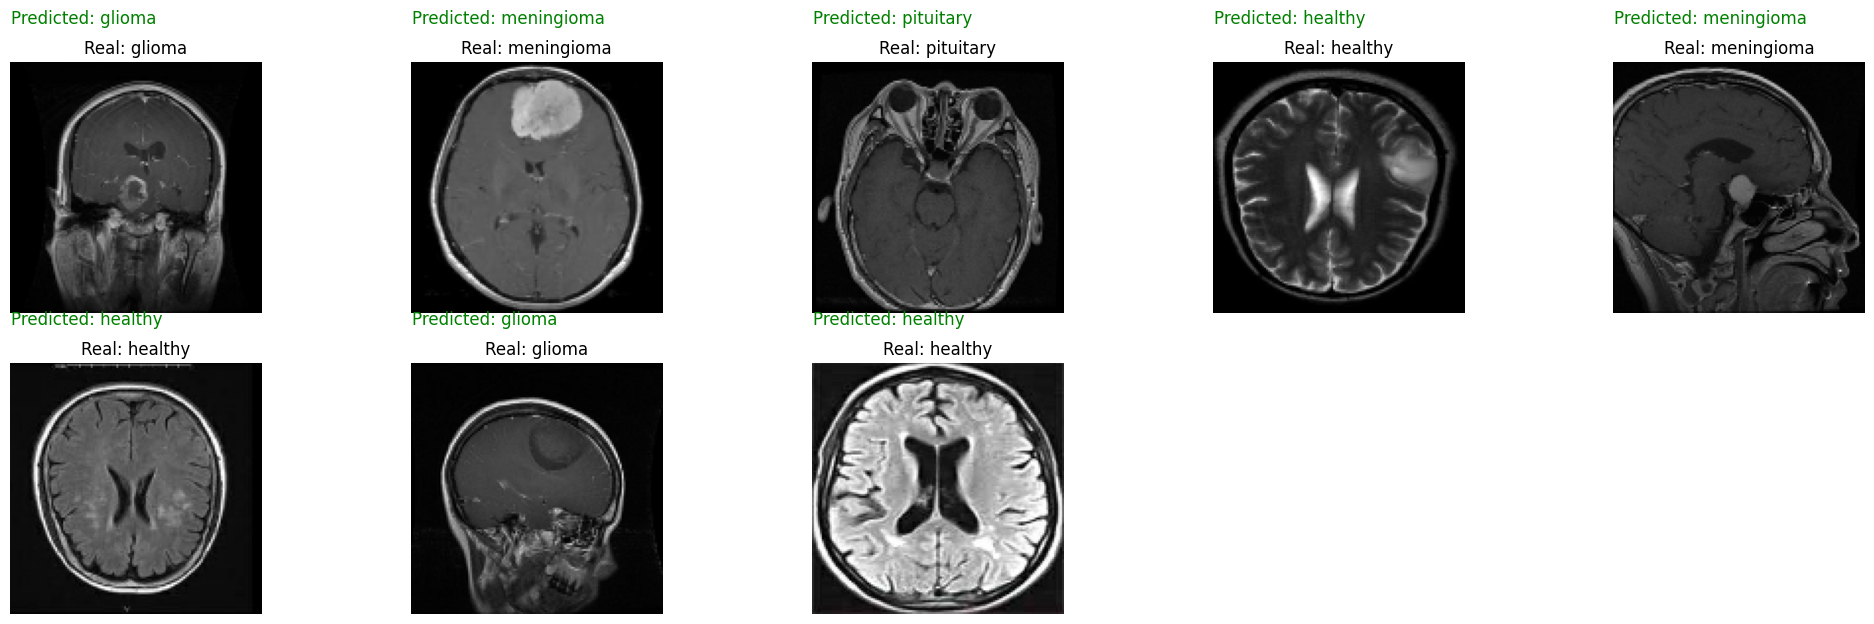

In [7]:
import matplotlib.pyplot as plt

# Obter as primeiras 20 imagens e seus rótulos do conjunto de validação
for images, labels in normalized_val_ds.take(1):
    images = images[:20]
    labels = labels[:20]

# Fazer previsões
predictions = model.predict(images)
predicted_labels = tf.argmax(predictions, axis=1)

# Plotar as imagens com suas previsões
plt.figure(figsize=(25, 15))
for i in range(8):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(f"Real: {class_names[labels[i]]}")
    plt.axis("off")
    plt.text(0, -20, f"Predicted: {class_names[predicted_labels[i]]}", 
             color="green" if class_names[predicted_labels[i]]==class_names[labels[i]] else "red", fontsize=12)
plt.show()

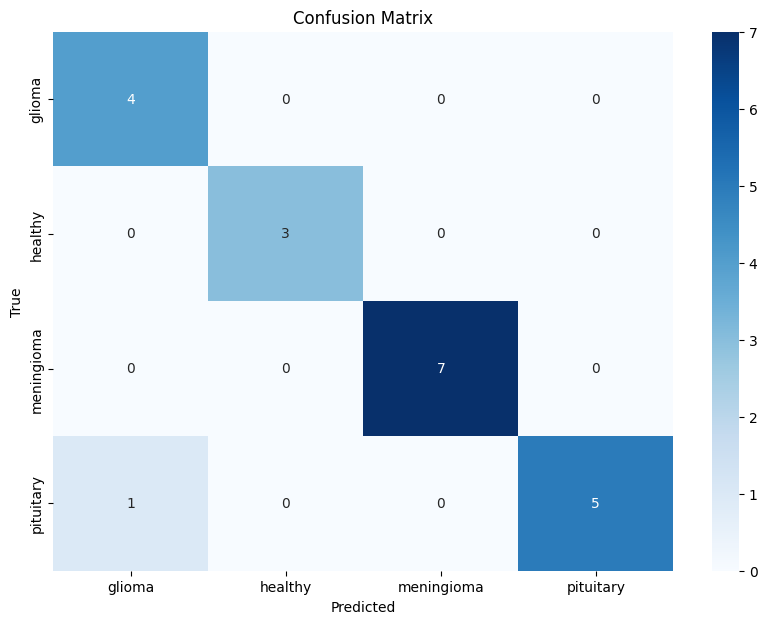

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcular a matriz de confusão
cm = confusion_matrix(labels, predicted_labels)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 13ms/step


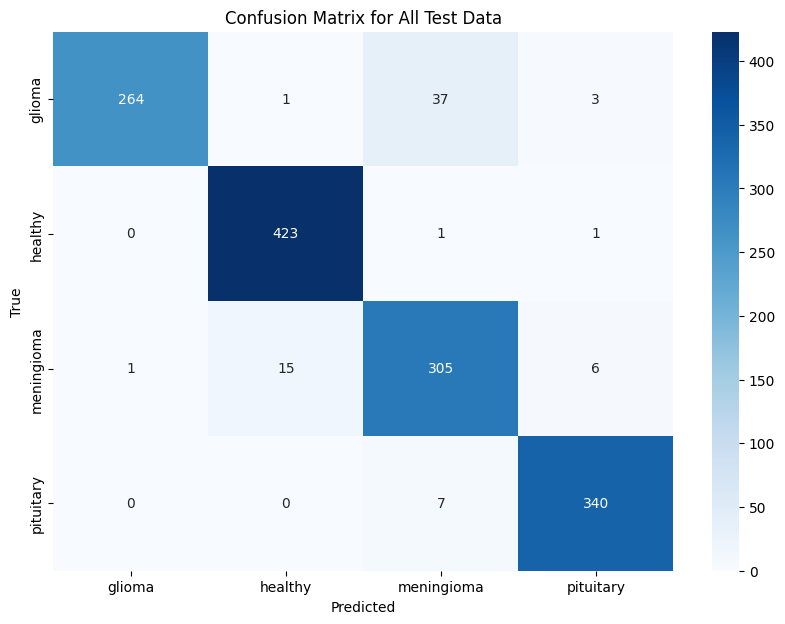

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Obter todas as imagens e rótulos do conjunto de validação
all_labels = []
all_predictions = []

for images, labels in normalized_val_ds:
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)
    all_labels.extend(labels.numpy())
    all_predictions.extend(predicted_labels.numpy())

# Calcular a matriz de confusão
cm_all = confusion_matrix(all_labels, all_predictions)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm_all, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for All Test Data')
plt.show()

In [9]:
teste_dir = 'meningioma.jpeg'
from tensorflow.keras.preprocessing import image
import numpy as np

# Carregar a imagem
img = image.load_img(teste_dir, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = normalization_layer(img_array)

# Fazer a previsão
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]

print(f"A imagem foi classificada como: {predicted_class}")


1/1 [==============================] - 0s 70ms/step
A imagem foi classificada como: meningioma


In [11]:
predictions*100

array([[2.7006370e-01, 5.9061829e-02, 6.3861168e+01, 3.5809711e+01]],
      dtype=float32)

In [12]:
teste_dir = 'Pituitary.jpg'
from tensorflow.keras.preprocessing import image
import numpy as np

# Carregar a imagem
img = image.load_img(teste_dir, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = normalization_layer(img_array)

# Fazer a previsão
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]

print(f"A imagem foi classificada como: {predicted_class}")

1/1 [==============================] - 0s 13ms/step
A imagem foi classificada como: pituitary


In [14]:
teste_dir = 'glioma.jpg'
from tensorflow.keras.preprocessing import image
import numpy as np

# Carregar a imagem
img = image.load_img(teste_dir, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = normalization_layer(img_array)

# Fazer a previsão
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]

print(f"A imagem foi classificada como: {predicted_class}")

1/1 [==============================] - 0s 13ms/step
A imagem foi classificada como: healthy
